In [74]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from PIL import Image


def caculate_hist_entropy(hist):
    p = hist / hist.sum()
    p = p[p > 0] # 移除概率为0的项
    return -np.sum(p * np.log2(p))

# 计算图片的信息熵
def caculate_entropy(image):
    hist = np.histogram(image, 256)[0]
    return caculate_hist_entropy(hist)

# K-means分割图像

def kmeans_image_segmentation(image, n_clusters=2):
    # 将图像转换为灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 将图像数据转换为二维数组
    h, w = gray.shape[:2]
    img_array = gray.reshape((-1, 1))
    
    # 使用KMeans进行聚类
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(img_array)
    
    # 将聚类结果映射回原始图像尺寸
    segmented_image = np.zeros((h, w), dtype=np.uint8)
    for i in range(len(labels)):
        segmented_image[i // w, i % w] = labels[i] * (255 // (n_clusters - 1))
    
    return segmented_image

# 下采样图像
def downsample_image(image_np, downsample_times, size = None):
    # 使用缩放因子来减半图片尺寸
    resized_image = cv2.resize(image_np, dsize=size, fx=1/downsample_times, fy=1/downsample_times, interpolation=cv2.INTER_AREA)
    return resized_image


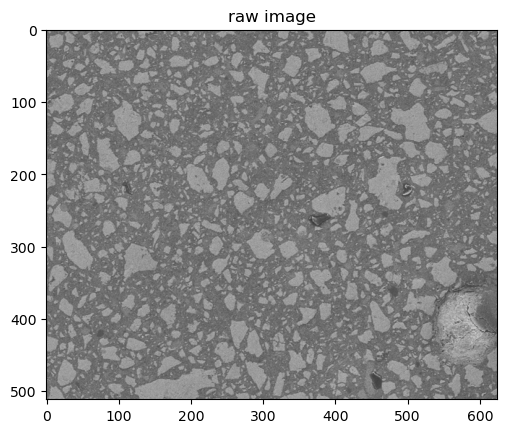

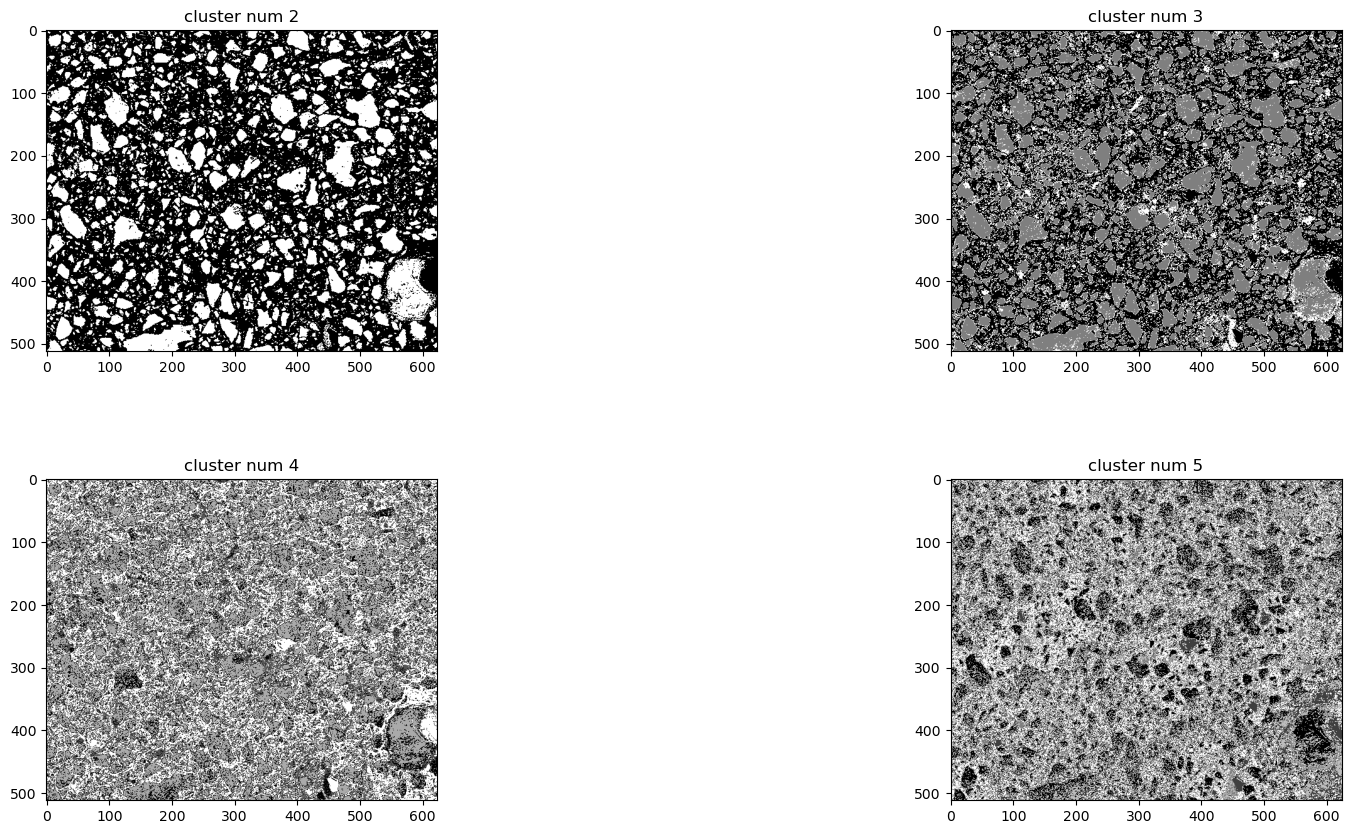

In [75]:

sample_index = 4
bse_sample_index = 2
zoom_times = 100
middle = zoom_times // 100
end_index = 1

file_name = f"{sample_index}-{middle}-{end_index}"
src_path = f"D:/workspace/ml-workspace/registration/datasets/sample{sample_index}/bse/s{bse_sample_index}/{zoom_times}"


ct_path = f"D:/workspace/ml-workspace/registration/datasets/sample4/ct/s1/585_enhanced.bmp"
# 读取图像
image = cv2.imread(f'{src_path}/{file_name}-enhanced-roi.bmp')
# image = cv2.imread(f'{ct_path}')


plt.imshow(image)
plt.title("raw image")
# 绘制画布
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[ 1, 1])

kmss = []
for i in range(4):
    num = i + 2
    # 使用KMeans进行图像分割
    segmented_image = kmeans_image_segmentation(image, num)

    # 把这个二值图进行保存
    cv2.imwrite(f'{src_path}/{file_name}-bse-kms{num}.bmp', segmented_image)
    kmss.append(segmented_image)
    ax = fig.add_subplot(gs[(i // 2) , i % 2])
    ax.imshow(segmented_image, cmap='gray', vmin=0, vmax=255)
    ax.set_title("cluster num {}".format(num))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

True

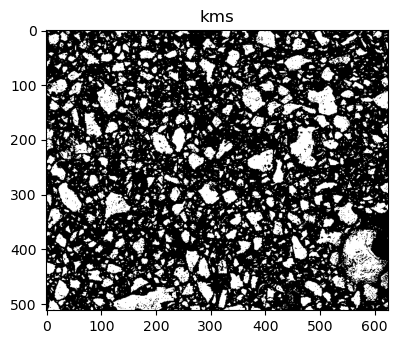

In [80]:
# 对操作进行腐蚀，去掉那些小的颗粒，尽量减少这些细节的干扰
# k-means结果显示，聚类成3类还算正常
# 读取图像

kms_suf = "kms3"
kms = cv2.imread(f'{src_path}/{file_name}-enhanced-roi-{kms_suf}.bmp', cv2.IMREAD_GRAYSCALE)


gray_cls = 127

neg_cls = kms != gray_cls
positive_cls = kms == gray_cls
kms[neg_cls] = 0
kms[positive_cls] = 255



plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1), plt.imshow(kms, cmap='gray',vmin=0, vmax=255), plt.title('kms')
# plt.subplot(2, 2, 2), plt.imshow(eroded_image, cmap='gray',vmin=0, vmax=255), plt.title('eroded_image')
# # plt.subplot(2, 2, 3), plt.imshow(floated_img, cmap='gray',vmin=0, vmax=255), plt.title('floated')
# # plt.subplot(2, 2, 4), plt.imshow(rotated, cmap='gray',vmin=0, vmax=255), plt.title('transform_origin')


cv2.imwrite(f'{src_path}/{file_name}-bse-filter-{kms_suf}.bmp', kms)




Text(0.5, 1.0, 'raw image')

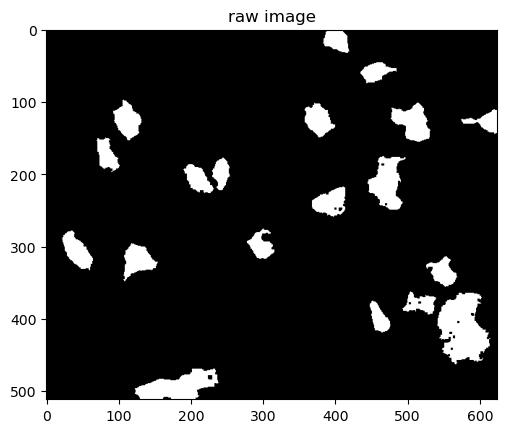

In [84]:
import cv2
import numpy as np

def erode_and_dilate_img(bin_img):
    # 定义核（kernel）的大小
    kernel_size = 3
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # 膨胀操作
    dilated_image = cv2.dilate(bin_img, kernel, iterations=1)

    # 腐蚀操作
    eroded_image = cv2.erode(dilated_image, kernel, iterations=1)
    return eroded_image


# 读取二值图像
bin_image = cv2.imread(f'{src_path}/{file_name}-bse-filter-{kms_suf}.bmp', 0)

# 寻找连通区域
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_image, 4, cv2.CV_32S)

# 设置大小阈值
size_threshold = 624

# 创建一个新的图像来存放结果
new_image = np.zeros_like(bin_image)

# 遍历所有连通区域
for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] >= size_threshold:
        # 如果连通区域的大小大于阈值，则将其添加到新图像中
        new_image[labels == i] = 255

new_image = erode_and_dilate_img(new_image)

cv2.imwrite(f"{src_path}/{file_name}-bse-masked.bmp", new_image)
# 显示或保存结果
plt.imshow(new_image, cmap="gray", vmin=0, vmax=255)
plt.title("raw image")

mean_bse_intensity: 154.69270567194687
masked entropy: 1.229785788119565


Text(0.5, 1.0, 'masked_white_region')

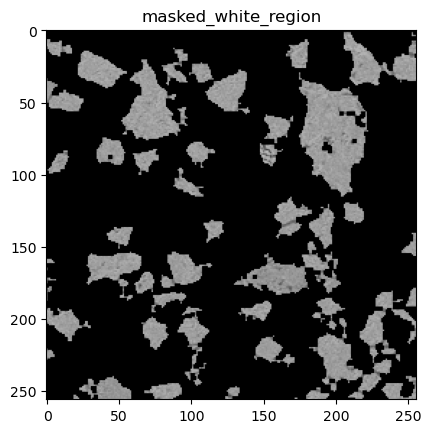

In [315]:
# 裁剪BSE增强图像以及二值图像
bse_img = Image.fromarray(image)
masked_img = Image.fromarray(new_image)


# 这里最好还是从中央进行裁剪(自己选吧)
center = (bse_img.width // 2, bse_img.height // 2)
start_left = 270
start_top = 0
cropped_width = 256
cropped_height = 256

offset_x = 50
offset_y = -130

center_left = center[0] + offset_x - cropped_width // 2
center_top = center[1] + offset_y - cropped_height // 2

# rect = (start_left, start_top, start_left+cropped_width, start_top+cropped_height)
rect = (center_left, center_top, center_left+cropped_width, center_top+cropped_height)

cropped_bse_img = bse_img.crop(rect)
cropped_bse_img = cropped_bse_img.convert('L')
cropped_masked_img = masked_img.crop(rect)
cropped_masked_img = cropped_masked_img.convert('L')

cropped_bse_img_np = np.array(cropped_bse_img)
cropped_masked_img_np = np.array(cropped_masked_img)

masked_white_region = cropped_bse_img_np & cropped_masked_img_np
cond_masked = cropped_masked_img_np > 0
indeces = np.where(cond_masked)
bse_masked_roi_flatten = masked_white_region[indeces]

mean_intensity = bse_masked_roi_flatten.sum() / cond_masked.sum()
# 用于bound的处理，但是对于ct图像的均值，可以使用其平均的
print(f"mean_bse_intensity: {mean_intensity}")

# # 再进行一次增强处理
# clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4, 4))
# # 设定参数
# sigma_color = 50
# sigma_space = 50
# kernel_size = 5
# 双边滤波：不对其边缘进行更改， 针对于水化产物区别较为明显的
# cropped_bse_img = cv2.bilateralFilter(np.array(cropped_bse_img), kernel_size, sigma_color, sigma_space)
# cropped_bse_img = Image.fromarray(clahe.apply(cropped_bse_img))
# cropped_bse_img = Image.fromarray(cropped_bse_img)
cropped_bse_img.save(f"{src_path}/{file_name}-matched-bse.bmp", format="BMP")
cropped_masked_img.save(f"{src_path}/{file_name}-matched-masked.bmp", format="BMP")

h_masked = caculate_entropy(downsample_image(cropped_masked_img_np, 2))
print(f"masked entropy: {h_masked}")

plt.imshow(masked_white_region, cmap="gray", vmin=0, vmax=255)
plt.title("masked_white_region")


In [19]:
masked_img = np.array([
    [0, 255, 255],
    [0, 0, 255]

])

img1 = np.array([
    [1, 80, 12],
    [0, 0, 90]

])
img2 = np.array([
    [1, 100, 30],
    [0, 0, 100]

])


# 带遮罩的空间信息
def spatial_correlation_with_mask(img1, img2):
    bound = [0, 50]
    lower_bound = bound[0]
    upper_bound = bound[1]
    img1_after_masked = img1 & masked_img
    img2_after_masked = img2 & masked_img
    diff_imgs = np.abs(img1_after_masked - img2_after_masked)
    res = (diff_imgs > lower_bound) & (diff_imgs <= upper_bound)
    count = np.sum(res)
    return count

spatial_correlation_with_mask(img1, img2)

[[False  True  True]
 [False False  True]]


3